# Современный анализ данных 11/01/2018

##  Методы обучение без учителя
### Алгоритмы кластеризации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

try:
    from ipywidgets import interact, IntSlider, fixed, FloatSlider
except ImportError:
    print u'Так надо'

# Ограничения метода k-средних
Запустите метод k-средних для данных ниже, расчитайте меру качества ARI по отношению к истинному разбиению в переменной `y` и меру `silhouette`.

Все должно получится идеально (ну или почти)!

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score

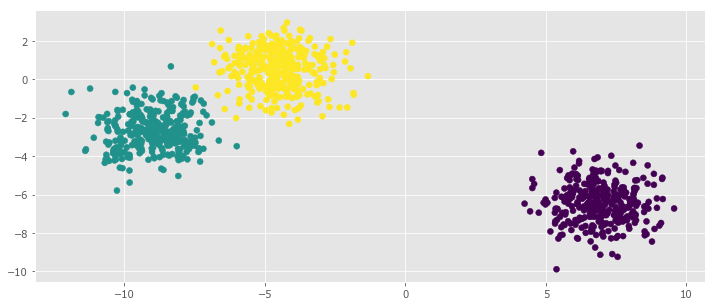

In [3]:
X, y = make_blobs(n_samples=1000, n_features=2,
                  centers=3, random_state=15)
plt.scatter(X[:,0], X[:,1], c=y)

#### Задание
Давайте чуть-чуть изменим данные.

Попробуем прокластеризовать их с помощью k-means и GMM (EM-алгоритма с гауссовскими распределениями).

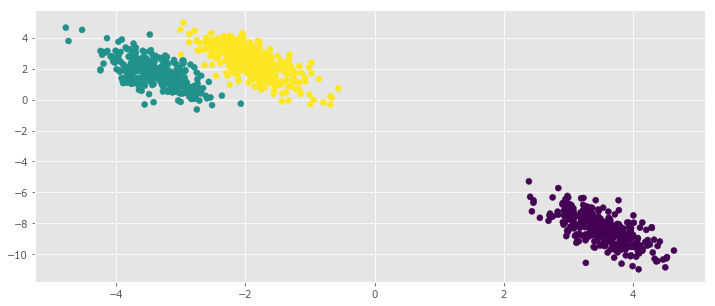

In [18]:
from sklearn.mixture import GaussianMixture
Trans = [[ 0.40834549, -0.43667341],
         [-0.10887718, 0.829]]
X_t = X.dot(Trans)
plt.scatter(X_t[:,0], X_t[:,1], c=y)

# Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

* Подготовте данные к кластеризации и сделайте иерарническую кластеризацию этого набора данных.
* Изобразите дендрограмму
* Выверите число кластеров и интерпретируйте их

Почему перед применением кластеризации признки необходимо нормализовать?

In [3]:
## Your Code Here
df = pd.read_csv('food.txt', sep=' ')
df.head()

,Name,Energy,Protein,Fat,Calcium,Iron
0,Braised beef,340,20,28,9,2.6
1,Hamburger,245,21,17,9,2.7
2,Roast beef,420,15,39,7,2.0
3,Beefsteak,375,19,32,9,2.6
4,Canned beef,180,22,10,17,3.7


# Геоданные

In [23]:
import mpl_toolkits.basemap as bm
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

Загрузите геоданные из `geo_data.txt` (lat, lon).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [106]:
df_geo = pd.read_csv('geo_data.txt', sep='\t', header=None,
                     names=['lat', 'lon'])/10000

In [107]:
df_geo.head()

,lat,lon
0,62.5983,29.7439
1,62.6146,29.7440
2,62.6144,29.7456
3,62.6004,29.7394
4,62.6018,29.7437


In [15]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print 'что-то пошло не так'
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [17]:
km_in_radian = 6371.0088
X = np.radians(df_geo.values)

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше (например MinPts = 20). Воспользуемся следующим способом оценки:

* Расчитайте расстояние до k=MinPts ближайшего соседа каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* По графику будет примерно понятно, сколько точек уйдет в шум, а сколько попадет в полноценный кластер

In [19]:
nn = NearestNeighbors()


NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='haversine',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Изобразите координаты точек, не попавших в кластер выбросов (метка -1)

## Кластеризация текстов

#### Загрузка и предобработка данных
* Загрузите тексты статей Википедии. Удобно будет работать через pandas.DataFrame
* Первое слово - название статьи. Лучше выделить его для удобства интерпретации.
* Чтобы наши компы не загнулись возьмем 20-40%% случайных статей для анализа
* Выполнить векторизацию текстов

#### Кластеризация DBSCAN
* Воспользуйтесь методом оценки параметров min_pts и epsilon из предыдущего задания
* В качестве метрики используйте cosine distance
* Найдите кластеры и попробуйте их интерпретировать

#### Кластеризация KMEANS
* Выберите количество кластеров с помощью метрики силуэта
* Используйте MiniBatchKmeans для скорости работы
* Найдите кластеры и попробуйте их интерпретировать